In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import uproot
import logging

import acts

from itertools import cycle

import awkward as ak

In [2]:
def plot_prototrack(prototrack):
    colors = [ c for i, c in zip(range(len(prototrack)), cycle(matplotlib.colors.TABLEAU_COLORS)) ]
    
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    fig.suptitle("Prototrack with ID {} and lenght {}".format(str(prototrack.trackId.to_list()[0]), len(prototrack)))

    # move around a bit so we see overlaps
    def randomify(x):
        d = max(x) - min(x)
        r = np.random.normal(0,0.01*d,len(x))
        return x + r
    
    ax[0].scatter(randomify(prototrack.z), randomify(np.hypot(prototrack.x, prototrack.y)), color=colors, marker="x")
    ax[1].scatter(randomify(prototrack.x), randomify(prototrack.y), color=colors, marker="x")

    return fig, ax

In [3]:
hits = uproot.open("../10events/hits.root:hits").arrays(library="pd")
hits = hits[ (hits.event_id == 0) & (hits.tt < 25.0) ].copy()
hits["hit_id"] = np.arange(len(hits))
hits.head(2)

simhit_map = pd.read_csv("../output/gnn_ckf_no_threshold/digi/event000000000-measurement-simhit-map.csv")
measId_to_hitID = dict(zip(simhit_map.measurement_id, simhit_map.hit_id))

prototracks = pd.read_csv("../output/gnn_ckf_no_threshold/gnn_plus_ckf/event000000000-prototracks.csv")
prototracks["hit_id"] = prototracks["measurementId"].map(measId_to_hitID)
prototracks["tx"] = prototracks.hit_id.map(dict(zip(hits.hit_id, hits.tx)))
prototracks["ty"] = prototracks.hit_id.map(dict(zip(hits.hit_id, hits.ty)))
prototracks["tz"] = prototracks.hit_id.map(dict(zip(hits.hit_id, hits.tz)))
prototracks["geometry_id"] = prototracks.hit_id.map(dict(zip(hits.hit_id, hits.geometry_id)))

hitId_to_particleId = dict(zip(hits.hit_id, hits.particle_id))
prototracks["particle_id"] = prototracks.hit_id.map(hitId_to_particleId)

prototracks.head(2)

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
0,0,25709,-25.141415,19.724676,-444.374018,25716,-25.129629,19.739695,-444.373993,1224979236083771648,243194380582649856
1,0,13707,-42.105389,32.421329,-615.600000,13709,-42.116688,32.409573,-615.599976,1152922604118475521,243194380582649856


In [4]:
measurements = pd.read_csv("../output/gnn_ckf_no_threshold/digi/event000000000-measurements.csv")
print("all",measurements.shape)
measurements["volume"] = measurements.geometry_id.map(lambda geoid: acts.GeometryIdentifier(geoid).volume())
measurements["hit_id"] = measurements.measurement_id.map(measId_to_hitID)
measurements["particle_id"] = measurements.hit_id.map(hitId_to_particleId)

measurements_pixel = measurements[ measurements.volume.isin([16,17,18]) ].copy()
print("pixel",measurements_pixel.shape)
measurements_pixel.head(2)

all (148722, 13)
pixel (69979, 16)


,measurement_id,geometry_id,local_key,local0,local1,phi,theta,time,var_local0,var_local1,var_phi,var_theta,var_time,volume,hit_id,particle_id
0,0,1152921779484754177,,-4.925,-24.972519,0,0,0,0.000208,0.000208,0,0,0,16,0,891712726538190854
1,1,1152921779484754177,,3.225,-30.625000,0,0,0,0.000208,0.000208,0,0,0,16,1,882705527350493184


In [5]:
prototracks_list = [ df for id, df in prototracks.groupby("trackId") ]
prototracks_list[0]

,trackId,measurementId,x,y,z,hit_id,tx,ty,tz,geometry_id,particle_id
0,0,25709,-25.141415,19.724676,-444.374018,25716,-25.129629,19.739695,-444.373993,1224979236083771648,243194380582649856
1,0,13707,-42.105389,32.421329,-615.600000,13709,-42.116688,32.409573,-615.599976,1152922604118475521,243194380582649856
2,0,14957,-42.220662,32.497944,-616.800000,14959,-42.238220,32.496037,-616.799988,1152922604118480897,243194380582649856
3,0,11473,-52.287404,39.685559,-715.600000,11475,-52.295258,39.678600,-715.599976,1152922466679522049,243194380582649856
4,0,12771,-52.396612,39.774757,-716.800000,12773,-52.418743,39.764217,-716.799988,1152922466679527425,243194380582649856
5,0,9247,-64.721088,48.249790,-835.600000,9248,-64.712738,48.239838,-835.599976,1152922329240568577,243194380582649856
6,0,10502,-64.841691,48.330749,-836.800000,10504,-64.838188,48.323662,-836.799988,1152922329240573953,243194380582649856
7,0,7069,-79.401532,57.822514,-975.600000,7070,-79.391426,57.840210,-975.599976,1152922191801615105,243194380582649856
8,0,6226,-95.059650,67.526324,-1123.200000,6227,-95.058914,67.512978,-1123.199951,1152922054362668802,243194380582649856
9,0,6242,-95.191303,67.573828,-1124.400000,6243,-95.187462,67.589729,-1124.400024,1152922054362669058,243194380582649856


(<Figure size 1000x300 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

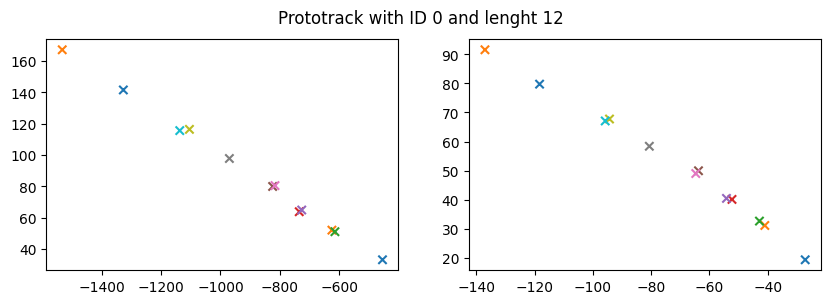

In [6]:
plot_prototrack(prototracks_list[0])

In [7]:
matched_df = pd.read_csv("../output/gnn_ckf_no_threshold/performance_gnn_plus_ckf.csv")
matched_df = matched_df[ matched_df.event == 0 ].copy()
matched_df.head(3)

,event,particle_id,matched
0,0,4503599644147712,1
1,0,4503599660924928,1
2,0,4503599677702144,1


In [8]:
not_matched = matched_df[ matched_df.matched == 0 ].copy()

print("total", len(matched_df))
print(f"not matched: {len(not_matched)} ({len(not_matched)/len(matched_df):.2%})")

df = pd.DataFrame()

for pid in not_matched.particle_id.to_numpy():
    info = {}
    
    trkMeasurements = measurements_pixel[ measurements_pixel.particle_id == pid ]
    info["nMeasPixel"] = len(trkMeasurements)
    
    trackIds = prototracks[ prototracks.particle_id == pid ].trackId.to_numpy()
    info["nTrackIds"] = len(trackIds)

    trackIds, count = np.unique(trackIds, return_counts=True)
    info["nUniqueTrackIds"] = len(trackIds)

    if len(trackIds) > 0:
        info["majTrackId"] = trackIds[np.argmax(count)]
        info["foundMajTrackIds"] = max(count)

        info["totalMajTrackIds"] = len(prototracks[ prototracks.trackId == info["majTrackId"] ])
    
    
    for k in info.keys():
        info[k] = [ info[k] ]
    
    df = pd.concat([df, pd.DataFrame(info)])

df = df.reset_index(drop=True)
df["pixel_track_eff"] = df.foundMajTrackIds / df.nMeasPixel
df["pixel_track_pur"] = df.foundMajTrackIds / df.totalMajTrackIds

df.head(3)

total 2817
not matched: 430 (15.26%)


,nMeasPixel,nTrackIds,nUniqueTrackIds,majTrackId,foundMajTrackIds,totalMajTrackIds,pixel_track_eff,pixel_track_pur
0,4,4,1,688.0,4.0,6.0,1.0,0.666667
1,5,0,0,NaN,NaN,NaN,NaN,NaN
2,5,0,0,NaN,NaN,NaN,NaN,NaN


In [9]:
min(df.nMeasPixel), min(df.foundMajTrackIds), min(df.totalMajTrackIds)

(3, 1.0, 3.0)

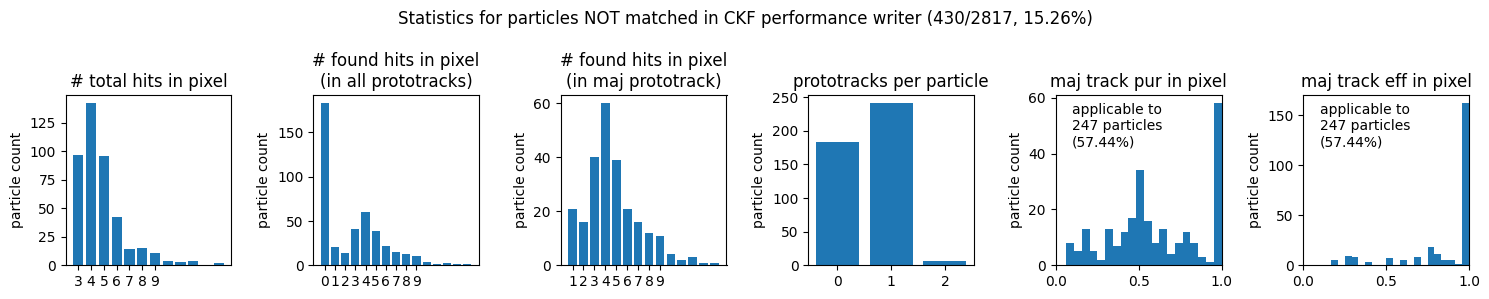

In [30]:
fig, ax = plt.subplots(1,6,figsize=(15,3))

ax[0].bar(*np.unique(df.nMeasPixel, return_counts=True))
ax[0].set_title("# total hits in pixel")
ax[0].set_ylabel("particle count")
ax[0].set_xticks(np.arange(min(df.nMeasPixel), 10))

ax[1].bar(*np.unique(df.nTrackIds, return_counts=True))
ax[1].set_title("# found hits in pixel\n(in all prototracks)")
ax[1].set_ylabel("particle count")
ax[1].set_xticks(np.arange(min(df.nTrackIds), 10))

ax[2].bar(*np.unique(df.foundMajTrackIds, return_counts=True))
ax[2].set_title("# found hits in pixel\n(in maj prototrack)")
ax[2].set_ylabel("particle count")
ax[2].set_xticks(np.arange(min(df.foundMajTrackIds), 10))

ax[3].bar(*np.unique(df.nUniqueTrackIds, return_counts=True))
ax[3].set_title("prototracks per particle")
ax[3].set_ylabel("particle count")
ax[3].set_xticks(np.arange(min(df.nUniqueTrackIds), max(df.nUniqueTrackIds)+1))

nFinite = sum(np.isfinite(df.pixel_track_pur))
ax[4].hist(df.pixel_track_pur, bins=20)
ax[4].set_title("maj track pur in pixel")
ax[4].text(0.1,0.7, "applicable to\n{} particles\n({:.2%})".format(nFinite, nFinite/len(df)), transform=ax[4].transAxes)
ax[4].set_ylabel("particle count")
ax[4].set_xlim(0,1)

nFinite = sum(np.isfinite(df.pixel_track_eff))
ax[5].hist(df.pixel_track_eff, bins=20)
ax[5].set_title("maj track eff in pixel")
ax[5].text(0.1,0.7, "applicable to\n{} particles\n({:.2%})".format(nFinite, nFinite/len(df)), transform=ax[5].transAxes)
ax[5].set_ylabel("particle count")
ax[5].set_xlim(0,1)

fig.suptitle(f"Statistics for particles NOT matched in CKF performance writer ({len(not_matched)}/{len(matched_df)}, {len(not_matched)/len(matched_df):.2%})")
fig.tight_layout()

In [31]:
"Number of umatched with 100% pur and efficient prototrack", len(df[ (df.pixel_track_eff == 1.0) & (df.pixel_track_pur == 1.0) ])

('Number of umatched with 100% pur and efficient prototrack', 55)

In [11]:
particles_df = pd.DataFrame()
particles_df["particle_id"] = np.unique(matched_df.particle_id)
particles_df.shape

(2817, 1)

In [12]:
class ZeroDict(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def __missing__(self, key):
        return 0

In [13]:
particles_df["n_meas"] = particles_df.particle_id.map(ZeroDict(measurements.groupby("particle_id")["particle_id"].count()))
particles_df["n_meas_pixel"] = particles_df.particle_id.map(ZeroDict(measurements_pixel.groupby("particle_id")["particle_id"].count()))
particles_df.shape

(2817, 3)

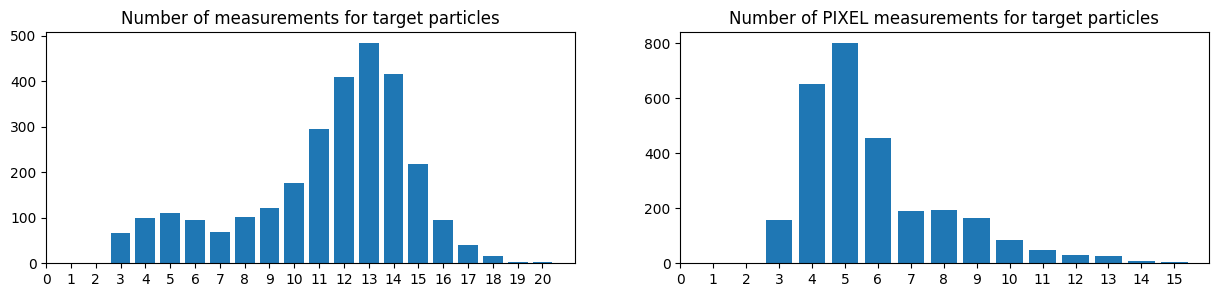

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,3))

ax[0].bar(*np.unique(np.clip(particles_df.n_meas, 0, 20), return_counts=True))
ax[0].set_title("Number of measurements for target particles")
ax[0].set_xticks(np.arange(21))

ax[1].bar(*np.unique(np.clip(particles_df.n_meas_pixel, 0, 15), return_counts=True))
ax[1].set_title("Number of PIXEL measurements for target particles")
_ = ax[1].set_xticks(np.arange(16))